In [1]:
import pandas as pd
import numpy as np
from glob import glob

from tqdm import tqdm

from sklearn.cluster import SpectralClustering
from scipy.spatial.distance import cosine

from deepface import DeepFace
from utils.visualize_pics import visualize_pics
from pathlib import Path

In [2]:
pics = glob('./norm_cut_faces/*.jpg')

In [3]:
embeddings = []
for pic in tqdm(pics):
    embedding = DeepFace.represent(pic, model_name='Facenet', enforce_detection=False)
    embeddings.append(embedding)

100%|██████████| 9000/9000 [1:03:05<00:00,  2.38it/s]


In [4]:
df = pd.DataFrame({'pics': pics, 'embeddings': embeddings})
df['embeddings'] = df['embeddings'].apply(lambda x: x[0]['embedding'])
df['embeddings'] = df['embeddings'].apply(lambda x: np.array(x))
df['pics'] = df['pics'].apply(lambda x: Path(x).name)
df['age'] = df['pics'].apply(lambda x: int(x[-4-4:-4])-int(x[-4-4-7-4:-4-7-4]))
df

,pics,embeddings,age
0,100012_1948-07-03_2008.jpg,"[-0.10485203564167023, 0.8846404552459717, 0.7...",60
1,10003541_1937-09-27_1971.jpg,"[0.22786423563957214, 0.45416250824928284, -3....",34
2,10004299_1908-08-19_1950.jpg,"[-0.6789429187774658, -1.7684248685836792, 0.7...",42
3,1000456_1933-06-12_1969.jpg,"[0.448852002620697, 0.13041724264621735, -0.89...",36
4,1000781_1930-07-07_2008.jpg,"[-0.28674450516700745, -2.011863946914673, -1....",78
...,...,...,...
8995,998422_1963-03-01_2009.jpg,"[-0.09385265409946442, 2.821779251098633, -1.8...",46
8996,999061_1913-08-26_2015.jpg,"[-0.4271005690097809, 1.129399299621582, -0.10...",102
8997,9994102_1992-03-13_2013.jpg,"[-0.9613540172576904, -0.05821862071752548, -2...",21
8998,9996412_1933-04-16_1963.jpg,"[1.4836881160736084, -0.3326588571071625, 0.81...",30


In [5]:
len(df)

9000

In [6]:
from sklearn.metrics.pairwise import pairwise_kernels
X=pairwise_kernels(df['embeddings'].tolist(), metric='cosine')
X=X-min(X.flatten())

In [26]:
model = SpectralClustering(affinity="precomputed", n_clusters=8,
                           assign_labels='cluster_qr').fit(X=X)

In [27]:
pd.Series(model.labels_).value_counts().sort_index()

0    1084
1    1062
2    1079
3    1150
4    1066
5    1086
6    1114
7    1359
Name: count, dtype: int64

In [28]:
df['cluster'] = model.labels_

min dist: 0.2597285290328427
mean age: 33 +- 13


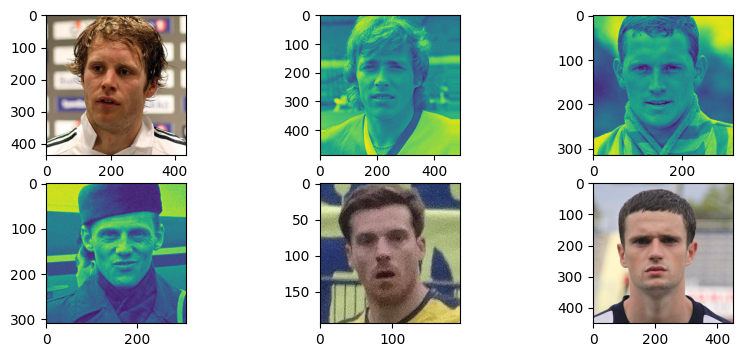

min dist: 0.295256578997956
mean age: 39 +- 17


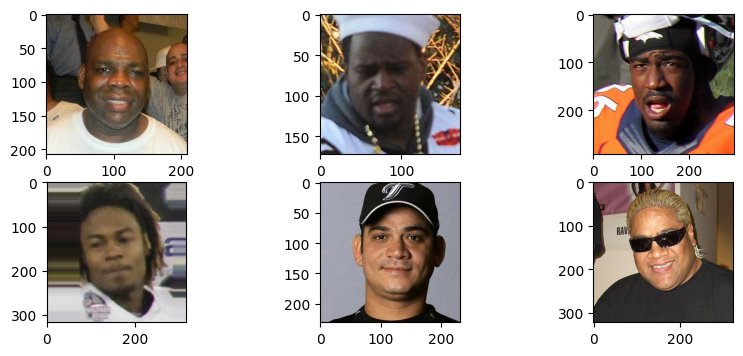

min dist: 0.31108801475862524
mean age: 43 +- 17


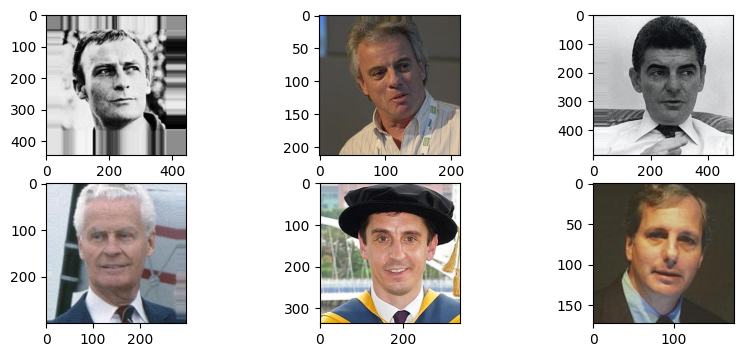

min dist: 0.33095241755632565
mean age: 32 +- 13


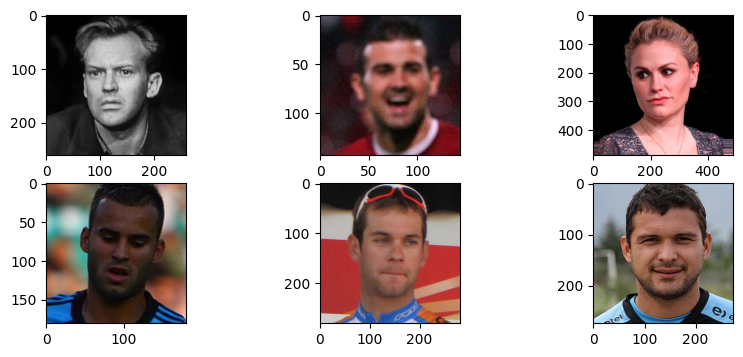

min dist: 0.2512913631219934
mean age: 48 +- 25


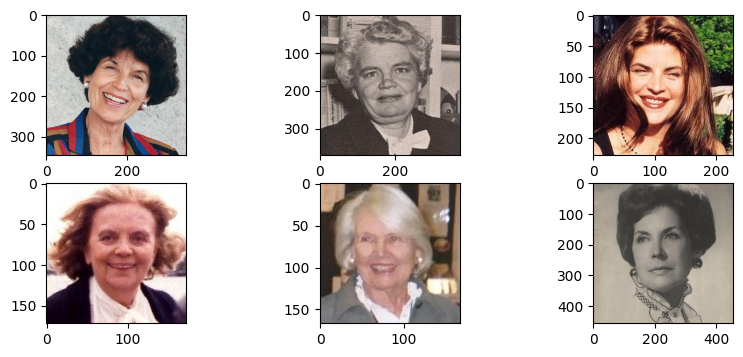

min dist: 0.32758833144875243
mean age: 38 +- 16


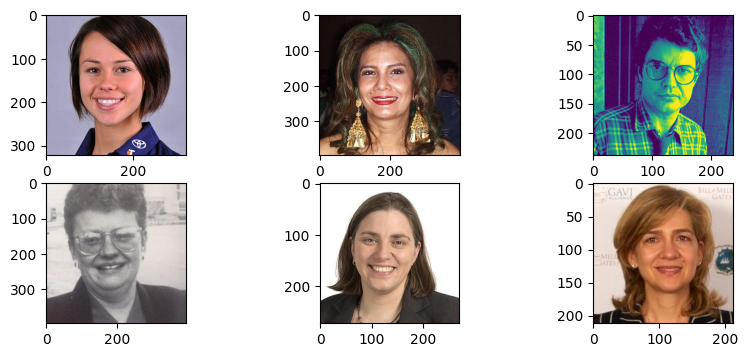

min dist: 0.330816938025733
mean age: 41 +- 17


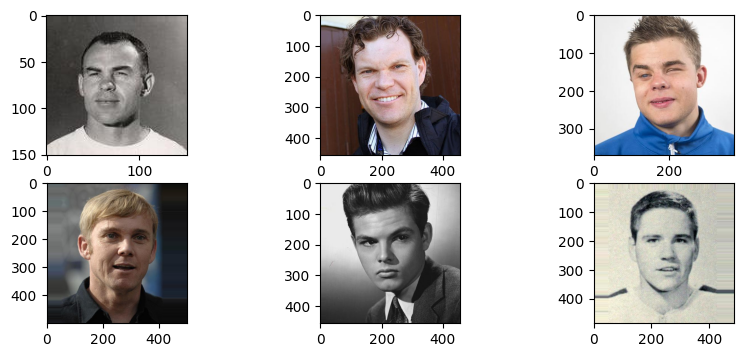

min dist: 0.267703852486024
mean age: 48 +- 17


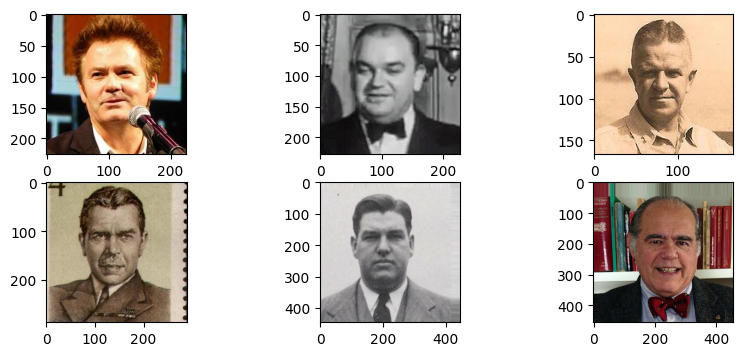

In [47]:
for i in range(8):
    cl = df[df['cluster']==i]
    avg = cl['embeddings'].mean()
    cl['dist'] = cl['embeddings'].apply(lambda x: cosine(x, avg))
    print('min dist:', cl['dist'].min())
    print('mean age:', round(ages.loc[i, 'mean']),
          '+-', round(ages.loc[i, 'std']))
    visualize_pics(cl.sort_values(by='dist', ascending=True)['pics'], source='./wiki_crop_all/', n=6)

In [45]:
ages=df.groupby(by='cluster')['age'].describe()
ages

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1084.0,32.988930,13.027489,8.0,24.0,29.0,38.25,100.0
1,1062.0,39.318267,16.742110,10.0,26.0,35.0,51.00,113.0
2,1079.0,42.707136,16.767687,0.0,29.0,40.0,53.00,101.0
3,1150.0,32.496522,12.979715,9.0,24.0,29.0,37.00,95.0
4,1066.0,47.834897,24.551162,10.0,32.0,46.0,60.00,585.0
5,1086.0,37.915285,16.133721,6.0,25.0,34.0,48.00,100.0
6,1114.0,40.914722,17.129728,9.0,27.0,37.0,53.00,114.0
7,1359.0,48.013981,17.013655,0.0,35.0,48.0,59.00,185.0
